# Random Forest

This script goes through all the random forest stuff.

### Data loading

In [7]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import json

from python_proj.utils.util import safe_save_fig, subtract_dict, Counter
import python_proj.utils.exp_utils as exp_utils

file_name = "dataset_90_days_started_11_07_23_preprocessed"
# base_path = '/workspaces/msc_thesis/data/'
# base_path= '/data/s4509412/data/data/'
base_path = exp_utils.BASE_PATH
data_path = f'{base_path}/final_data/{file_name}.csv'
print(f'{data_path=}')
figure_base_path = f"{base_path}/figures/modelling/{file_name}/"

# Meta stuff.
pr_merged_key = 'PullRequestIsMerged'
ftc_key = 'SubmitterIsFirstTimeContributor'
seed_counter = Counter()


# Loads regular dataframe.
df: pd.DataFrame = pd.read_csv(filepath_or_buffer=data_path, header=0)
df = df.drop(['Unnamed: 1', 'Project Name.1'], axis=1) # removes accidentally added fields.
if True:
    df = df.sample(math.floor(len(df) * 0.1))
    print((5 * "#########\n") +
          "YOU'RE USING A RANDOM SUBSAMPLE OF 10%!!!\n" + (5 * "#########\n"))
print(df.columns)

# Loads first-time contributor data frame.
ftc_df = df[df[ftc_key]]
print(f'{len(df)=}')
print(f'{len(ftc_df)=}')

# Creates sub-datasets.
metadata_fields = ['ID', 'Project Name',
                   'Submitter ID', 'PR Number', 'Closed At']
dependent_fields = [pr_merged_key]
independent_fields = [field for field in df.columns
                      if (field not in metadata_fields
                          and field not in dependent_fields)]

# Removes fields with only columns from ftc dataset.
ftc_columns_old = ftc_df.columns
ftc_df = ftc_df.loc[:, (ftc_df != 0).any()]
ftc_columns_new = ftc_df.columns
ftc_removed = [field for field in ftc_columns_old
               if field not in ftc_columns_new]
print(f'{ftc_removed=}')

df[independent_fields].describe()


data_path='/workspaces/msc_thesis/data//final_data/dataset_90_days_started_11_07_23_preprocessed.csv'
#########
#########
#########
#########
#########
YOU'RE USING A RANDOM SUBSAMPLE OF 10%!!!
#########
#########
#########
#########
#########

Index(['Project Name', 'ID', 'Submitter ID', 'PR Number', 'Closed At',
       'PullRequestIsMerged', 'ControlIntegratedBySameUser',
       'ControlPullRequestHasComments',
       'ControlPullRequestHasCommentByExternalUser',
       'ControlHasHashTagInDescription',
       'IntraProjectSubmitterPullRequestSuccessRate',
       'EcosystemExperienceSubmitterPullRequestSuccessRate',
       'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate',
       'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate',
       'SubmitterIsFirstTimeContributor',
       'ln(1 + ControlPullRequestLifeTimeInMinutes)',
       'ln(1 + ControlNumberOfCommitsInPullRequest)',
       'ln(1 + FirstOrderDegreeCentralityV2(PRIntegratorToSubmitter.PRInte

,IntraProjectSubmitterPullRequestSuccessRate,EcosystemExperienceSubmitterPullRequestSuccessRate,DependencyEcosystemExperienceSubmitterPullRequestSuccessRate,InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,ln(1 + ControlPullRequestLifeTimeInMinutes),ln(1 + ControlNumberOfCommitsInPullRequest),ln(1 + FirstOrderDegreeCentralityV2(PRIntegratorToSubmitter.PRIntegratorToSubmitter-In)),ln(1 + FirstOrderDegreeCentralityV2(PRIntegratorToSubmitter.PRCommenterToSubmitter-In)),ln(1 + FirstOrderDegreeCentralityV2(PRIntegratorToSubmitter.PRCommenterToCommenter-In)),ln(1 + FirstOrderDegreeCentralityV2(PRIntegratorToSubmitter.IssueCommenterToCommenter-In)),...,ln(1 + IntraProjectSubmitterIssueCommentCount),ln(1 + SharedExperienceIssueSubmittedBySubmitterCommentedOnByIntegrator),ln(1 + SharedExperienceIssueSubmittedByIntegratorCommentedOnBySubmitter),ln(1 + SharedExperienceIssueDiscussionParticipationByIntegratorAndSubmitter),ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + EcosystemExperienceSubmitterIssueCommentCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount)
count,122081.000000,122081.000000,122081.000000,122081.000000,122081.000000,122081.000000,122081.000000,122081.000000,122081.000000,122081.000000,...,122081.000000,122081.000000,122081.000000,122081.000000,122081.000000,122081.000000,122081.000000,122081.000000,122081.000000,122081.000000
mean,0.502095,0.404589,0.099594,0.059445,6.442908,1.092624,0.463508,0.463302,0.437337,0.343237,...,1.012633,0.146218,0.087538,0.391018,0.676141,1.295745,0.068930,0.137554,0.063420,0.139951
std,0.470915,0.452877,0.292253,0.228975,3.449638,0.660251,0.991760,0.997234,1.058697,0.919106,...,1.492578,0.491888,0.395549,1.058753,0.965858,1.624292,0.322716,0.555679,0.351191,0.657796
min,0.000000,0.000000,0.000000,0.000000,0.016529,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,3.660566,0.693147,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.666667,0.000000,0.000000,0.000000,6.802228,0.693147,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.693147,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.941176,0.000000,0.000000,8.985013,1.386294,0.693147,0.693147,0.000000,0.000000,...,1.791759,0.000000,0.000000,0.000000,1.098612,2.302585,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,15.279417,8.524566,12.662576,11.026809,11.644620,11.462064,...,7.507690,5.267858,5.323010,8.323366,6.609349,7.923710,4.709530,6.638568,6.609349,7.921173


## Regular Model

### Train test data creation

In [8]:
from sklearn.model_selection import train_test_split

def calculate_class_imbalance():
    # Calculates class imbalance.
    class_counts = df[pr_merged_key].value_counts()
    class_imbalance = max(class_counts) / min(class_counts)
    print(f'{class_counts=}')
    print(f'{class_imbalance=}\n')
    return class_imbalance


class_imbalance = calculate_class_imbalance()


def is_majority_class(label) -> bool:
    """
    Helper method for standardizing majority 
    class filtering later in the notebook.
    """

    # NOTE: You have to manually change this
    # if the majority class is different.
    return label


def get_imbalance_weights(__df):
    return list([1.0 if is_majority_class(label) else class_imbalance
                 for label in __df])


# Makes 80:20 dataset splits for testing/training
train, test = train_test_split(df, test_size=0.2)
print(f'{len(train)=}, {len(test)=}\n')

# Labels
train_labels = train[pr_merged_key]
test_labels = test[pr_merged_key]

# Predictors
train_predictors = train[independent_fields]
test_predictors = test[independent_fields]

# Imbalance weights
train_imbalance_weights = get_imbalance_weights(train_labels)
test_imbalance_weights = get_imbalance_weights(test_labels)

class_counts=PullRequestIsMerged
True     96083
False    25998
Name: count, dtype: int64
class_imbalance=3.6957842910993155

len(train)=97664, len(test)=24417



### Full Model Creation

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, roc_auc_score


def calculate_metrics(predicted_labels, true_labels, sample_weights=None):
    return {
        "accuracy": accuracy_score(true_labels, predicted_labels, sample_weight=sample_weights),
        "precision": precision_score(true_labels, predicted_labels, sample_weight=sample_weights),
        "recall": recall_score(true_labels, predicted_labels, sample_weight=sample_weights),
        "f1": f1_score(true_labels, predicted_labels, sample_weight=sample_weights)
    }


def create_model(predictor_labels):
    # Model creation and predictions.
    random_state = seed_counter.get_next()
    print(f'{random_state=}')
    rf = RandomForestRegressor(
        n_estimators=100,
        random_state=random_state)

    r_train_predictors = train_predictors[predictor_labels]
    r_test_preditors = test_predictors[predictor_labels]

    rf.fit(r_train_predictors, train_labels)

    predictions = rf.predict(r_test_preditors)
    predictions = [pred >= 0.5 for pred in predictions]

    # F1 scores.
    conf = confusion_matrix(test_labels, predictions)

    metrics = calculate_metrics(predictions, test_labels)

    print(f'{metrics=}\n')

    # Other metrics.
    print(f'Confusion matrix:\n{conf}\n')
    print("Classification report:")
    print(classification_report(test_labels, predictions))

    return rf, metrics


print(independent_fields)
# These are more or less equally good.

full_rf_model, full_rf_metrics = create_model(independent_fields)


['ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlPullRequestHasCommentByExternalUser', 'ControlHasHashTagInDescription', 'IntraProjectSubmitterPullRequestSuccessRate', 'EcosystemExperienceSubmitterPullRequestSuccessRate', 'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'SubmitterIsFirstTimeContributor', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + FirstOrderDegreeCentralityV2(PRIntegratorToSubmitter.PRIntegratorToSubmitter-In))', 'ln(1 + FirstOrderDegreeCentralityV2(PRIntegratorToSubmitter.PRCommenterToSubmitter-In))', 'ln(1 + FirstOrderDegreeCentralityV2(PRIntegratorToSubmitter.PRCommenterToCommenter-In))', 'ln(1 + FirstOrderDegreeCentralityV2(PRIntegratorToSubmitter.IssueCommenterToCommenter-In))', 'ln(1 + FirstOrderDegreeCentralityV2(PRIntegratorToSubmitter.IssueCommenterToSubmitter-In))', 'ln(1 + FirstOrderDegreeCen

### Control Model Creation

Creates a random forest model using the different control variables AND intra-project experience.

In [13]:
import regex as re


controls = [field for field in df.columns if
            len(list(re.findall(r'.*Control.*', field))) > 0]
controls = list(controls)
controls.append('IntraProjectSubmitterPullRequestSuccessRate')
print(controls)


# unweigthed model: weighted_f1=0.83 and unweighted_f1=0.93
control_rf_model, control_rf_metrics = create_model(controls)


diff_weighted_full_vs_control = subtract_dict(
    full_rf_metrics, control_rf_metrics)


print("Comparison full model vs. control model: (negatives means the control is better)")
print(f'Metrics: \n{json.dumps(diff_weighted_full_vs_control, indent=4)}\n')


['ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlPullRequestHasCommentByExternalUser', 'ControlHasHashTagInDescription', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)', 'IntraProjectSubmitterPullRequestSuccessRate']
random_state=44
metrics={'accuracy': 0.8310603268214768, 'precision': 0.8717822513166313, 'recall': 0.9209650582362728, 'f1': 0.8956990062959872}

Confusion matrix:
[[ 2580  2605]
 [ 1520 17712]]

Classification report: 
              precision    recall  f1-score   support

       False       0.63      0.50      0.56      5185
        True       0.87      0.92      0.90     19232

    accuracy                           0.83     24417
   macro avg       0.75      0.71      0.73     24417
weighted avg       0.82      0.83      0.82     24417

Comparison full model vs. control model: (negatives means the control is better)
Metrics: 
{
    "prec

### Non-Control Model

Creates model with only ecosystem + shared predictors

In [14]:
import regex as re
non_control_fields = [field for field in independent_fields
                      if field not in controls and
                      len(re.findall(r'.*Intra.*', field)) == 0]

print(non_control_fields)

non_control_rf_model, non_control_rf_metrics = create_model(non_control_fields)


diff_unweighted_full_vs_non_control = subtract_dict(
    full_rf_metrics, non_control_rf_metrics)


print("Comparison full model vs. non-control model: (negatives means the non-control is better)")
print(f'Metrics: \n{json.dumps(diff_weighted_full_vs_control, indent=4)}\n')


['EcosystemExperienceSubmitterPullRequestSuccessRate', 'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'SubmitterIsFirstTimeContributor', 'ln(1 + FirstOrderDegreeCentralityV2(PRIntegratorToSubmitter.PRIntegratorToSubmitter-In))', 'ln(1 + FirstOrderDegreeCentralityV2(PRIntegratorToSubmitter.PRCommenterToSubmitter-In))', 'ln(1 + FirstOrderDegreeCentralityV2(PRIntegratorToSubmitter.PRCommenterToCommenter-In))', 'ln(1 + FirstOrderDegreeCentralityV2(PRIntegratorToSubmitter.IssueCommenterToCommenter-In))', 'ln(1 + FirstOrderDegreeCentralityV2(PRIntegratorToSubmitter.IssueCommenterToSubmitter-In))', 'ln(1 + FirstOrderDegreeCentralityV2(PRCommenterToSubmitter.PRIntegratorToSubmitter-In))', 'ln(1 + FirstOrderDegreeCentralityV2(PRCommenterToSubmitter.PRCommenterToSubmitter-In))', 'ln(1 + FirstOrderDegreeCentralityV2(PRCommenterToSubmitter.PRCommenterToCommenter-In))', 'ln(1 + FirstOrderDegreeCentralityV2(PRCo

### Calculate feature importance through exclusion.

In [16]:

def test_importance_through_exclusion(__full_rf_metrics: dict,
                                      _independent_df: pd.DataFrame):
    f1_differences_per_feature = {}

    for feature in _independent_df.columns:
        print(f"Creating model without: {feature}.")
        excl_df: pd.DataFrame = _independent_df.columns.drop(feature)

        excl_rf_model, excl_rf_metrics = create_model(excl_df)

        diff_weighted_full_vs_feature_excl = subtract_dict(
            __full_rf_metrics, excl_rf_metrics)

        f1_differences_per_feature[feature] = {
            'Weighted metrics': excl_rf_metrics,
            'Weighted metrics difference': diff_weighted_full_vs_feature_excl,
        }

    return f1_differences_per_feature


diffs_per_feature = test_importance_through_exclusion(
    full_rf_metrics, train_predictors)
print("Comparison full model vs. models with single features excluded: (negatives means the model with excluded features is better)")
print(f'{json.dumps(diffs_per_feature, indent=4)}')


Creating model without: ControlIntegratedBySameUser.
Index(['ControlPullRequestHasComments',
       'ControlPullRequestHasCommentByExternalUser',
       'ControlHasHashTagInDescription',
       'IntraProjectSubmitterPullRequestSuccessRate',
       'EcosystemExperienceSubmitterPullRequestSuccessRate',
       'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate',
       'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate',
       'SubmitterIsFirstTimeContributor',
       'ln(1 + ControlPullRequestLifeTimeInMinutes)',
       'ln(1 + ControlNumberOfCommitsInPullRequest)',
       'ln(1 + FirstOrderDegreeCentralityV2(PRIntegratorToSubmitter.PRIntegratorToSubmitter-In))',
       'ln(1 + FirstOrderDegreeCentralityV2(PRIntegratorToSubmitter.PRCommenterToSubmitter-In))',
       'ln(1 + FirstOrderDegreeCentralityV2(PRIntegratorToSubmitter.PRCommenterToCommenter-In))',
       'ln(1 + FirstOrderDegreeCentralityV2(PRIntegratorToSubmitter.IssueCommenterToCommenter-In))',
  

### Partial Dependence Plots

Generates partial dependence plots of the full model using the test data.

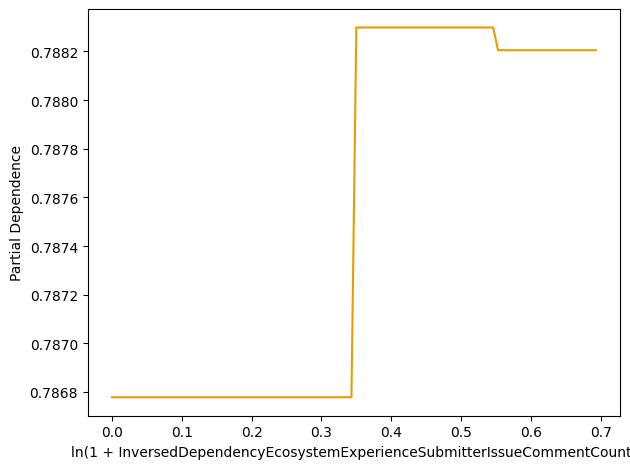

In [17]:
from sklearn.inspection import PartialDependenceDisplay
from matplotlib import pyplot as plt


def create_partial_dependence_plots(
        __rf, __df,
        __used_predictor_labels,
        model_name: str = "",
        average_only=True):
    
    if average_only:
        # Collective partial dependence plot.
        PartialDependenceDisplay.from_estimator(
            __rf, __df, __used_predictor_labels)

        fig = plt.gcf()
        axs = fig.axes

        lines = []
        for ax in axs:
            __lines = list([(line.get_xdata(), line.get_ydata())
                            for line in ax.lines])
            lines.extend(__lines)

        for (x, y), label in zip(lines, __used_predictor_labels):
            plt.clf()
            plt.plot(x, y, linestyle='-', color='#e69d00')
            plt.xlabel(label)
            plt.ylabel('Partial Dependence')
            plt.tight_layout()
            output_path = f"{figure_base_path}/partial-dependence/{model_name}/{label}.png"
            safe_save_fig(output_path)

    else:
        # TODO: create a plot where the average response is displayed
        # as a line, and the min/max as a grey area around it.
        pdd = PartialDependenceDisplay.from_estimator(
            __rf, __df, __used_predictor_labels, kind='individual')


create_partial_dependence_plots(full_rf_model,
                                test_predictors, train_predictors.columns,
                                model_name="full_model")


## First-time contributor Control

### Generate Train and Test data

In [ ]:
# NOTE: this is more-or-less copied from above.

from sklearn.model_selection import train_test_split

def calculate_class_imbalance():
    # Calculates class imbalance.
    class_counts = ftc_df[pr_merged_key].value_counts()
    class_imbalance = max(class_counts) / min(class_counts)
    print(f'{class_counts=}')
    print(f'{class_imbalance=}\n')
    return class_imbalance


class_imbalance = calculate_class_imbalance()


def is_majority_class(label) -> bool:
    """
    Helper method for standardizing majority 
    class filtering later in the notebook.
    """

    # NOTE: You have to manually change this
    # if the majority class is different.
    return label


def get_imbalance_weights(__df):
    return list([1.0 if is_majority_class(label) else class_imbalance
                 for label in __df])


# Makes 80:20 dataset splits for testing/training
train, test = train_test_split(ftc_df, test_size=0.2)
print(f'{len(train)=}, {len(test)=}\n')

# Labels
train_labels = train[pr_merged_key]
test_labels = test[pr_merged_key]

# Imbalance weights
train_imbalance_weights = get_imbalance_weights(train_labels)
test_imbalance_weights = get_imbalance_weights(test_labels)

# Predictors
train_predictors = train[ftc_independent.columns]
test_predictors = test[ftc_independent.columns]

print(f'{len(ftc_independent.columns)=}')
print(f'{ftc_independent.columns=}')

ftc_independent.describe()


class_counts=PullRequestIsMerged
True     33791
False    19719
Name: count, dtype: int64
class_imbalance=1.713626451645621

len(train)=42808, len(test)=10702

len(ftc_independent.columns)=15
ftc_independent.columns=Index(['ControlIntegratedBySameUser', 'ControlPullRequestLifeTimeInMinutes',
       'ControlPullRequestHasComments', 'ControlNumberOfCommitsInPullRequest',
       'ControlPullRequestHasCommentByExternalUser',
       'ControlHasHashTagInDescription',
       'ControlIntraProjectPullRequestExperienceOfIntegrator',
       'IntraProjectSubmitterPullRequestCommentCount',
       'EcosystemExperienceSubmitterPullRequestSuccessRate',
       'EcosystemExperienceSubmitterPullRequestSubmissionCount',
       'EcosystemExperienceSubmitterPullRequestCommentCount',
       'SharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator',
       'SharedExperiencePullRequestSubmittedByIntegratorIntegratedBySubmitter',
       'EcosystemExperienceSubmitterIssueSubmissionCount',
       'Ec

,ControlPullRequestLifeTimeInMinutes,ControlNumberOfCommitsInPullRequest,ControlIntraProjectPullRequestExperienceOfIntegrator,IntraProjectSubmitterPullRequestCommentCount,EcosystemExperienceSubmitterPullRequestSuccessRate,EcosystemExperienceSubmitterPullRequestSubmissionCount,EcosystemExperienceSubmitterPullRequestCommentCount,SharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator,SharedExperiencePullRequestSubmittedByIntegratorIntegratedBySubmitter,EcosystemExperienceSubmitterIssueSubmissionCount,EcosystemExperienceSubmitterIssueCommentCount
count,5.351000e+04,53510.000000,53510.000000,53510.000000,53510.000000,53510.000000,53510.000000,53510.000000,53510.000000,53510.000000,53510.000000
mean,6.204227e+04,5.523939,832.328387,0.326780,0.379868,21.743412,50.815418,0.596318,0.137918,13.444272,82.606167
std,2.022817e+05,104.848987,3132.980379,6.694169,0.410387,95.114850,300.041861,8.248864,3.499906,52.679561,436.912648
min,1.666667e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.747208e+02,1.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.157467e+03,1.000000,39.000000,0.000000,0.142857,1.000000,1.000000,0.000000,0.000000,1.000000,3.000000
75%,2.180527e+04,2.000000,234.000000,0.000000,0.800000,7.000000,9.000000,0.000000,0.000000,7.000000,20.000000
max,4.386997e+06,10000.000000,31442.000000,993.000000,1.000000,3793.000000,12560.000000,563.000000,354.000000,2527.000000,14098.000000


### Full Model

In [ ]:

ftc_unweighted_rf, ftc_unweighted_weighted_metrics, ftc_unweighted_unweighted_metrics = create_model(
    train_predictors.columns, False)

ftc_weighted_rf,  ftc_weighted_weighted_metrics, ftc_weighted_unweighted_metrics = create_model(
    train_predictors.columns, True)

ftc_diff_weighted = subtract_dict(
    ftc_unweighted_weighted_metrics, ftc_weighted_weighted_metrics)
ftc_diff_unweighted = subtract_dict(
    ftc_unweighted_unweighted_metrics, ftc_weighted_unweighted_metrics)

print("Comparison first-time contributor model with weighted training vs. unweighted training (negative means weighted is better):")
print(f'Unweighted metrics: \n{json.dumps(ftc_diff_weighted, indent=4)}\n')
print(f'Weighted metrics: \n{json.dumps(ftc_diff_unweighted, indent=4)}\n')

ftc_full_weighted_metrics = ftc_unweighted_weighted_metrics
ftc_full_unweighted_metrics = ftc_unweighted_unweighted_metrics


random_state=63
Training unweighted model
unweighted_metrics={'accuracy': 0.7703233040553168, 'precision': 0.7862068965517242, 'recall': 0.87511071744907, 'f1': 0.8282800055889339}
weighted_metricss={'accuracy': 0.7328150668981775, 'precision': 0.6821346890459546, 'recall': 0.87511071744907, 'f1': 0.7666657736001623}
conf=array([[2316, 1612],
       [ 846, 5928]])
              precision    recall  f1-score   support

       False       0.82      0.59      0.69 6731.124702064333
        True       0.68      0.88      0.77    6774.0

    accuracy                           0.73 13505.124702064333
   macro avg       0.75      0.73      0.73 13505.124702064333
weighted avg       0.75      0.73      0.73 13505.124702064333

random_state=64
Training weighted model
unweighted_metrics={'accuracy': 0.7724724350588675, 'precision': 0.7845992391446936, 'recall': 0.8829347505166815, 'f1': 0.8308675418489962}
weighted_metricss={'accuracy': 0.7329328893163881, 'precision': 0.68006290657505, 'recall'

### Control Model

In [ ]:
controls = ['ControlIntegratedBySameUser',
            'ControlPullRequestLifeTimeInMinutes',
            'ControlPullRequestHasComments',
            'ControlNumberOfCommitsInPullRequest',
            'ControlPullRequestHasCommentByExternalUser',
            'ControlHasHashTagInDescription',
            'ControlIntraProjectPullRequestExperienceOfIntegrator',
            'IntraProjectSubmitterPullRequestCommentCount']


ftc_control_model, ftc_control_weighted_metrics, ftc_control_unweighted_metrics = create_model(
    controls, False)

ftc_diff_unweighted_full_vs_control = subtract_dict(
    ftc_full_unweighted_metrics, ftc_control_unweighted_metrics)
ftc_diff_weighted_full_vs_control = subtract_dict(
    ftc_full_weighted_metrics, ftc_control_weighted_metrics)

print("First-time contributor control model metrics:")
print(
    f'Unweighted metrics: {json.dumps(ftc_control_unweighted_metrics, indent=4)=}\n')
print(
    f'Weighted metrics: {json.dumps(ftc_control_weighted_metrics, indent=4)=}\n')

print("Comparison first-time contributor full model vs. control model: (negatives means the control is better)")
print(
    f'Difference unweighted metrics: \n{json.dumps(ftc_diff_unweighted_full_vs_control, indent=4)}\n')
print(
    f'Difference weighted metrics: \n{json.dumps(ftc_diff_weighted_full_vs_control, indent=4)}\n')


random_state=65
Training unweighted model
unweighted_metrics={'accuracy': 0.7455615772752756, 'precision': 0.7750916745891621, 'recall': 0.8424859757897845, 'f1': 0.8073848765650421}
weighted_metricss={'accuracy': 0.7108678749683534, 'precision': 0.667894287346773, 'recall': 0.8424859757897845, 'f1': 0.7450992099582201}
conf=array([[2272, 1656],
       [1067, 5707]])
              precision    recall  f1-score   support

       False       0.78      0.58      0.67 6731.124702064333
        True       0.67      0.84      0.75    6774.0

    accuracy                           0.71 13505.124702064333
   macro avg       0.73      0.71      0.71 13505.124702064333
weighted avg       0.73      0.71      0.71 13505.124702064333

First-time contributor control model metrics:
Unweighted metrics: json.dumps(ftc_control_unweighted_metrics, indent=4)='{\n    "accuracy": 0.7455615772752756,\n    "precision": 0.7750916745891621,\n    "recall": 0.8424859757897845,\n    "f1": 0.8073848765650421\n}'

W

### Feature Importance through exclusion

In [ ]:
diffs_per_feature = test_importance_through_exclusion(ftc_full_weighted_metrics, ftc_full_unweighted_metrics, ftc_independent)
print("Performance scores of models when excluding a feature and a comparison with the full model (negative scores means the model with an excluded feature is better).")
print(f'{json.dumps(diffs_per_feature, indent=4)}')

random_state=66
Training unweighted model
unweighted_metrics={'accuracy': 0.7037936834236591, 'precision': 0.733117723156533, 'recall': 0.8365810451727193, 'f1': 0.7814396028681744}
weighted_metricss={'accuracy': 0.6562629763029554, 'precision': 0.6158302360486967, 'recall': 0.8365810451727193, 'f1': 0.70942977265961}
conf=array([[1865, 2063],
       [1107, 5667]])
              precision    recall  f1-score   support

       False       0.74      0.47      0.58 6731.124702064333
        True       0.62      0.84      0.71    6774.0

    accuracy                           0.66 13505.124702064333
   macro avg       0.68      0.66      0.64 13505.124702064333
weighted avg       0.68      0.66      0.64 13505.124702064333

random_state=67
Training unweighted model
unweighted_metrics={'accuracy': 0.7035133619884134, 'precision': 0.7267346681778114, 'recall': 0.8519338647770889, 'f1': 0.7843696907917092}
weighted_metricss={'accuracy': 0.650386834314133, 'precision': 0.6081413978548771, 'rec

### Partial dependence plots

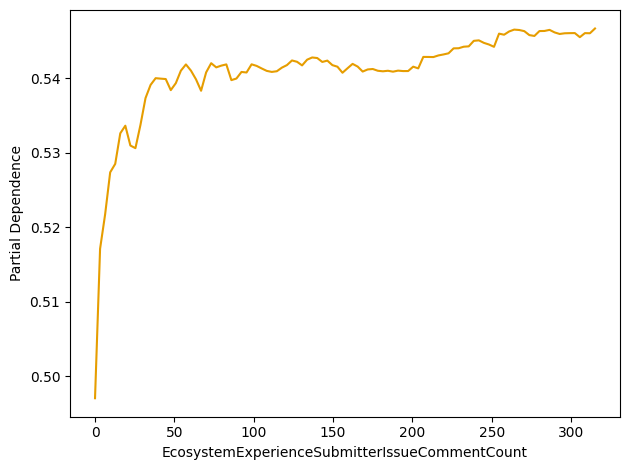

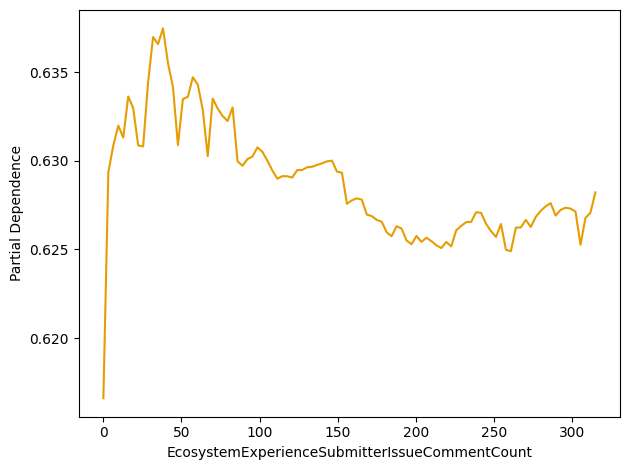

In [ ]:
create_partial_dependence_plots(ftc_weighted_rf,
                                test_predictors, ftc_independent.columns,
                                model_name="ftc_weighted")

create_partial_dependence_plots(ftc_unweighted_rf,
                                test_predictors, ftc_independent.columns,
                                model_name="ftc_unweighted")

## Dependency Ecosystem Control